# Entropic maps by Yseult Masson and Théo Gérard

---



# Definition

Our goal is to find an optimal map between two probability distributions $P$ and $Q$ (on $\Omega \subseteq \mathbb{R}^d$) that solves the Monge problem with respect to the squared Euclidian norm :

$$\min_{T \in \mathcal{T}(P, Q)} \int \frac{1}{2} \|x - T(x)\|_2^2 \, dP(x)$$

The entropic map (Pooladian and Niles-Weed, 2022) is an estimator of such a map based on samples $X_1, ..., X_n \sim P$ and $Y_1, ..., Y_n \sim Q$. It is defined as :

$$\hat{T}(x) = \frac{\frac{1}{n} \sum_{i=1}^n Y_i e^{\frac{1}{\epsilon} \left(g_{ɛ, (n, n)}(Y_i) - \frac{1}{2} \|x - Y_i\|^2 \right)}}{\frac{1}{n} \sum_{k=1}^n e^{\frac{1}{\epsilon} \left(g_{ɛ, (n, n)}(Y_i) - \frac{1}{2} \|x - Y_k\|^2 \right)}}$$

where $g_{ɛ, (n, n)}$ is the entropic potential corresponding to $Q_n$ in the optimal entropic plan between $P_n = \frac{1}{n} \sum_{i=1}^{n} \delta_{X_i}$ and $Q_n = \frac{1}{n} \sum_{i=1}^{n} \delta_{Y_i}$. This potential is obtained with Sinkhorn’s algorithm. \\

# Statistical properties

Under some regularity assumptions on $P$ and $Q$, the authors obtain the following bound :

$$\mathbb{E}\left\| \hat{T} - T_0 \right\|_{L^2(P)}^2 \leq C \left(1 + I_0(P, Q)\right)n^{-\frac{(\bar{\alpha} + 1)}{2(d' + \bar{\alpha} + 1)}} \log n
$$

Here, $\varepsilon = n^{\frac{-1}{(\bar{\alpha} + d' + 1)}}$ (up to a constant), $d' = 2\left\lceil \frac{d}{2} \right\rceil$ and $\bar\alpha = \alpha \wedge 3$. This is not as good as the minimax optimal rate, but the computationnal cost of the entropic map is much lower than those of other estimators in the litterature. Moreover, the authors claim that empirical experiments show a better convergence rate than the one stated above, so this bound may not be tight. \\




# Imports

In [ ]:
!pip install ott-jax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.5/265.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Any, Tuple
from scipy.linalg import fractional_matrix_power
from tqdm import tqdm
import time

import jax
import jax.numpy as jnp
import jax.random as random
from functools import partial
from jax import jit

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

# Path to save the results in Google Drive
# result_path = '/content/drive/My Drive/Optimal_transport'
result_path = None
if result_path is not None:
    from google.colab import drive

    drive.mount("/content/drive")

PRNGKey = Any
Shape = Tuple[int]
Dtype = Any
Array = Any

Mounted at /content/drive


# Sampler for the source distribution

In [ ]:
def uniform_sampler(key_n, n_dim, low_bound, high_bound):
    """Sample a point from a n_dim uniform distribution."""
    Y = random.uniform(key_n, (n_dim,), minval=low_bound, maxval=high_bound)
    return Y


class UniformSampler:
    def __init__(self, dim: int = 2, low_bound=-1, high_bound=1):
        self.dim = dim
        self.low_bound = low_bound
        self.high_bound = high_bound

        self.setup()

    def setup(self):
        """Create a uniform sampler."""

        @partial(jit, static_argnums=1)
        def generate_samples(key, num_samples):
            """
            Take a random key and a number of samples as input.
            Return an array of points drawn iid from a uniform distribution.
            """
            key_n = jax.random.split(key, num=num_samples)
            points = jax.vmap(
                lambda x: uniform_sampler(x, self.dim, self.low_bound, self.high_bound)
            )(key_n)

            return points

        self.generate_samples = generate_samples

In [ ]:
def solve(X, Y, epsilon):
    """Return the entropic map between source samples X and target samples Y through Sinkhorn's algorithm, with regularization epsilon."""

    geom = ott.geometry.pointcloud.PointCloud(X, Y, epsilon=epsilon)
    problem = ott.problems.linear.linear_problem.LinearProblem(geom)
    solver = ott.solvers.linear.sinkhorn.Sinkhorn()
    out = solver(problem)
    entropic_map = out.to_dual_potentials()

    return entropic_map

# Visualization of an entropic map estimator on synthetic data

We take $P$ a uniform distribution on $[-1, 1]^2$ and draw $n=500$ iid samples from it. We define the optimal map as $T_0(x) = exp(x)$ coordinate-wise.

In [ ]:
T0 = jnp.exp

In [ ]:
rng = jax.random.PRNGKey(42)
rng_train, rng_test = jax.random.split(rng, num=2)

n = 500
d = 2
epsilon = jnp.pow(n, -1 / (3 + 2 * jnp.ceil(d / 2) + 1))

source_sampler = UniformSampler(dim=d, low_bound=-1, high_bound=1)

# Draw n_samples iid samples from the source distribution (uniform [-1, 1]^d)
X = source_sampler.generate_samples(rng_train, n)

# Compute the target samples
Y = T0(X)

# Get the entropic map
entropic_map = solve(X, Y, epsilon)
T = entropic_map.transport

In [ ]:
# Sample a new set of samples from [-1, 1]^d
X_prime = source_sampler.generate_samples(rng_test, 100)

# Compute the transported samples with the optimal map
Y_prime = T0(X_prime)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

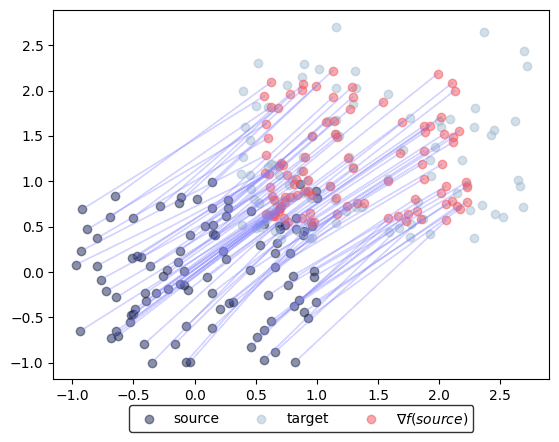

In [ ]:
# Plot the transported samples
entropic_map.plot_ot_map(X_prime, Y_prime)

$X'$ are the source samples, $Y'=T_0(X')$ the target samples, and $\nabla f (source) = T(X')$ the samples transported with the entropic map.

# Illustration of the statistical properties of the entropic map estimator on synthetic data

In this section, we illustrate the statistical properties of the entropic map estimator on synthetic data. As in the previous section, we take $P$ to be a uniform distribution on $[-1, 1]^d$ and draw $n$ iid samples from it. We define the optimal map as $T_0(x) = exp(x)$ coordinate-wise. In this case, $\bar\alpha = 3$ and $I_0(P, Q)$ can be bounded by a constant. \\

Our goal is to compare the entropic map estimator $T$ to the optimal map $T_0$, and retrieve the bound :

$$\mathbb{E}\left\| T - T_0 \right\|_{L^2(P)}^2 \leq C n^{-\frac{(\bar{\alpha} + 1)}{2(d' + \bar{\alpha} + 1)}} \log n$$

In [ ]:
def integral_approximation(
    T, T0, rng_uniform, dim, low_bound, high_bound, n_integration_samples
):
    """Approximate the squared norm L2(P) of T0 - T through Monte Carlo integration."""

    x = random.uniform(
        rng_uniform, (n_integration_samples, dim), minval=low_bound, maxval=high_bound
    )
    fun = lambda x: jnp.linalg.norm(T(x) - T0(x), 2)
    return jnp.mean(
        jax.vmap(fun)(x)
    )  # The 1/(high_bound-low_bound)^d (of the uniform PDF) and the (high_bound-low_bound)^d (of the Monte Carlo integration) cancel out.


def expectation_error_rate_entropic_maps(
    T0=jnp.exp,
    dim=2,
    n_samples=1024,
    n_steps=50,
    n_integration_samples=10000,
    low_bound=-1,
    high_bound=1,
    alpha=3,
    verbose=True,
):
    """Return an approximation of the expected error between the optimal transport map T0 and the entropic map."""

    # Define regularization term
    alpha_macron = min(alpha, 3)
    d_prime = 2 * jnp.ceil(dim / 2)
    epsilon = jnp.pow(n_samples, -1 / (alpha_macron + d_prime + 1))

    # Initiate sampler
    source_sampler = UniformSampler(dim=dim, low_bound=low_bound, high_bound=high_bound)

    solve_time = 0
    integration_time = 0
    results = 0

    # Compute the error n_steps times and average in order to approximate the expectation
    for i in range(n_steps):

        rng = jax.random.PRNGKey(i)
        rng_generation_source, rng_uniform = jax.random.split(rng, num=2)

        # Draw n_samples iid samples from the source distribution (uniform [-1, 1]^d)
        X = source_sampler.generate_samples(rng_generation_source, n_samples)

        # Compute the target samples
        Y = T0(X)

        # Compute the entropic map through Sinkhorn's algorithm
        start = time.process_time()
        entropic_map = solve(X, Y, epsilon)
        solve_time += time.process_time() - start

        # Transport map
        T = entropic_map.transport

        # Compute the squared L2(P) norm of T0 - T
        start = time.process_time()
        result = integral_approximation(
            T, T0, rng_uniform, dim, low_bound, high_bound, n_integration_samples
        )
        integration_time += time.process_time() - start

        results += result

    if verbose:
        print("Solving time : ", solve_time, sep="\n")
        print("Integration time : ", integration_time, sep="\n")

    return results / n_steps

In [ ]:
def compute_errors(d_list, n_list, T0, result_path=None, strategy="exp"):
    """Return a dataframe containing, for d in d_list and n in n_list, the expected errors between T0 and the entropic map estimator."""

    # Compute the array of errors
    results = np.zeros((len(n_list), len(d_list)))
    for j, d in enumerate(tqdm(d_list)):
        for i, n in enumerate(n_list):
            results[i, j] = expectation_error_rate_entropic_maps(
                T0, dim=d, n_samples=n, verbose=False
            )

    # Convert to dataframe
    df_results = pd.DataFrame(results, index=n_list, columns=d_list)

    # Save a csv
    if result_path is not None:
        df_results.to_csv(f"{result_path}/results_{strategy}.csv")

    return df_results

In [ ]:
def rate_computation(n, d, alpha_macron=3):
    """Return the theoretical bound from the entropic maps paper."""
    d_prime = 2 * jnp.ceil(d / 2)
    power = -(alpha_macron + 1) / (2 * (d_prime + alpha_macron + 1))
    return np.power(n, power) * np.log(n)


def plot_errors(df_errors, alpha=3, const=1, log_scale=False):
    """Plot experimental errors vs theoretical rates."""
    d_list = df_errors.columns
    n_list = df_errors.index
    n_range = np.linspace(min(n_list), max(n_list), 20)

    alpha_macron = min(alpha, 3)

    fig, axs = plt.subplots(
        int(np.ceil(len(d_list) / 2)), 2, figsize=(10, 7), sharey=True
    )
    axs = axs.flat

    for i, d in enumerate(d_list):
        ax = axs[i]

        # Plot experimental results
        results = df_errors[d]
        ax.plot(df_errors.index, results, label="Experimental error")

        # Plot theoretical rate
        rate = const * rate_computation(n_range, d)
        ax.plot(n_range, rate, label="Theoretical rate")

        ax.set_title(f"d={d}")
        ax.legend()
        ax.set_ylabel("Error")

        if log_scale:
            ax.set_xscale("log")
            ax.set_xlabel("Number of samples (logarithmic scale)")
        else:
            ax.set_xlabel("Number of samples")

    plt.tight_layout()
    plt.show()

We compute the experimental errors $\mathbb{E}\left\| T - T_0 \right\|_{L^2(P)}^2$ for different values of $n$ and $d$ and compare them to the theoretical rate $C n^{-\frac{(\bar{\alpha} + 1)}{2(d' + \bar{\alpha} + 1)}} \log n$.

100%|██████████| 6/6 [18:52<00:00, 188.80s/it]


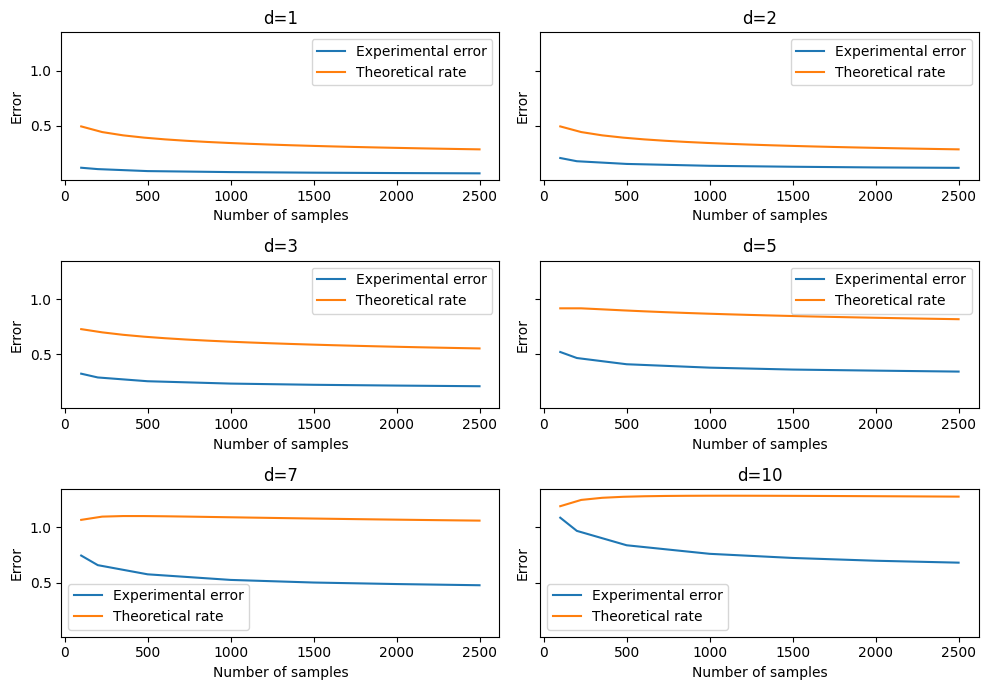

In [ ]:
df = compute_errors(
    d_list=[1, 2, 3, 5, 7, 10],
    n_list=[100, 200, 500, 1000, 1500, 2000, 2500],
    T0=jnp.exp,
    result_path=result_path,
)

plot_errors(df, const=0.5)

For smaller dimensions (up to d=5), the experimental error rate is quite similar to the theoretical rate up to a constant. This is less true for higher dimensions, but that may be due to computational approximations (in the Monte Carlo integration especially).

# Entropic maps on real data


In this section, we will apply the entropic maps previously defined to real-world data. We will utilize the Heart Disease dataset from the UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/45/heart+disease).

This dataset contains 13 features (e.g., age, cholesterol, blood pressure, heart rate) and a target variable indicating the type of heart disease. For visualization purposes, we will focus on two features: age and cholesterol (in mg/dl), and the target denoting whether a person has heart disease or not.

Since the experiments were conducted across multiple locations, the dataset includes information about the individual's locations amongst Cleveland, Hungary, Switzerland, and the VA Long Beach. In this instance, we will take individuals from Hungary as the source domain and transport them to the target domain, which consists of individuals from Cleveland.

In [ ]:
# Download dataset
!gdown 1mk_T8LKbIssCsCtZ1181V707J2yxPtio

Downloading...
From: https://drive.google.com/uc?id=1mk_T8LKbIssCsCtZ1181V707J2yxPtio
To: /content/heart_disease_uci.csv
100% 79.3k/79.3k [00:00<00:00, 4.58MB/s]


In [ ]:
df = pd.read_csv("heart_disease_uci.csv")
df["disease"] = (df["num"] > 0).apply(int)
df = df[["age", "chol", "dataset", "disease"]]
df = df.dropna()
df.head()

,age,chol,dataset,disease
0,63,233.0,Cleveland,0
1,67,286.0,Cleveland,1
2,67,229.0,Cleveland,1
3,37,250.0,Cleveland,0
4,41,204.0,Cleveland,0


In [ ]:
# Define source (Hungary) and target (Cleveland)
df_Hungary = df[df["dataset"] == "Hungary"]
X_source, y_source = df_Hungary[["age", "chol"]].values, df_Hungary["disease"].values

df_Cleveland = df[df["dataset"] == "Cleveland"]
X_target, y_target = (
    df_Cleveland[["age", "chol"]].values,
    df_Cleveland["disease"].values,
)

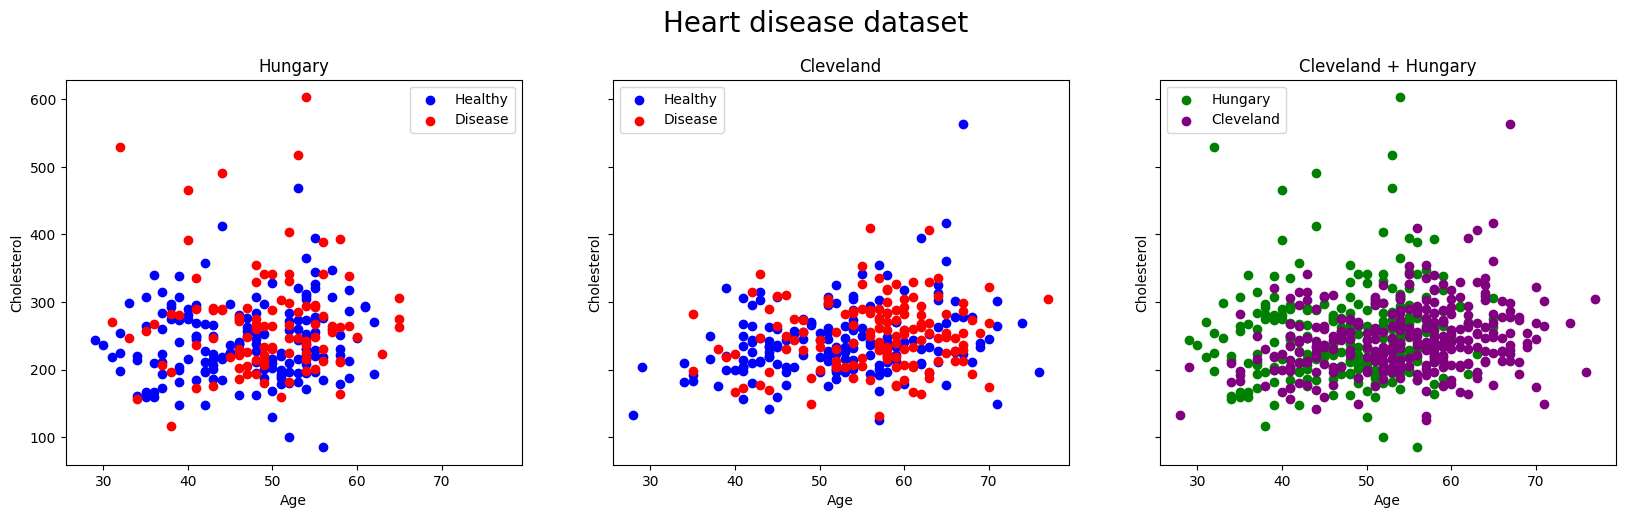

In [ ]:
# Plot original distributions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)


healthy_points_source = X_source[y_source == 0]
disease_points_source = X_source[y_source == 1]

healthy_points_target = X_target[y_target == 0]
disease_points_target = X_target[y_target == 1]


ax1.scatter(
    healthy_points_source[:, 0], healthy_points_source[:, 1], c="blue", label="Healthy"
)
ax1.scatter(
    disease_points_source[:, 0], disease_points_source[:, 1], c="red", label="Disease"
)

ax2.scatter(
    healthy_points_target[:, 0], healthy_points_target[:, 1], c="blue", label="Healthy"
)
ax2.scatter(
    disease_points_target[:, 0], disease_points_target[:, 1], c="red", label="Disease"
)

ax3.scatter(X_source[:, 0], X_source[:, 1], c="green", label="Hungary")
ax3.scatter(X_target[:, 0], X_target[:, 1], c="purple", label="Cleveland")


ax1.set_xlabel("Age")
ax1.set_ylabel("Cholesterol")
ax1.set_title("Hungary")

ax2.set_xlabel("Age")
ax2.set_ylabel("Cholesterol")
ax2.set_title("Cleveland")

ax3.set_xlabel("Age")
ax3.set_ylabel("Cholesterol")
ax3.set_title("Cleveland + Hungary")


ax1.legend()
ax2.legend()
ax3.legend()

plt.suptitle("Heart disease dataset", fontsize=20, y=1.02)
plt.show()

We can see that the data don't share exactly the same distribution, amongst other things it is more skewed to the right for the Hungarian individuals. Thus, if we were to apply directly a model trained on the Cleveland data it would have difficulty to understand the hungarian part of the dataset.

Therefore, we can use the entropic map to do domain adaptation.

In [ ]:
alpha = 3
dim = X_source.shape[1]
n_samples = X_source.shape[0]
alpha_macron = min(alpha, 3)
d_prime = 2 * jnp.ceil(dim / 2)
epsilon = jnp.pow(n_samples, -1 / (alpha_macron + d_prime + 1))

# Solve the transport problem with Sinkhorn's algorithm
entropic_map = solve(X_source, X_target, epsilon)

# Transport the Hungary points
X_transport_source = entropic_map.transport(X_source)

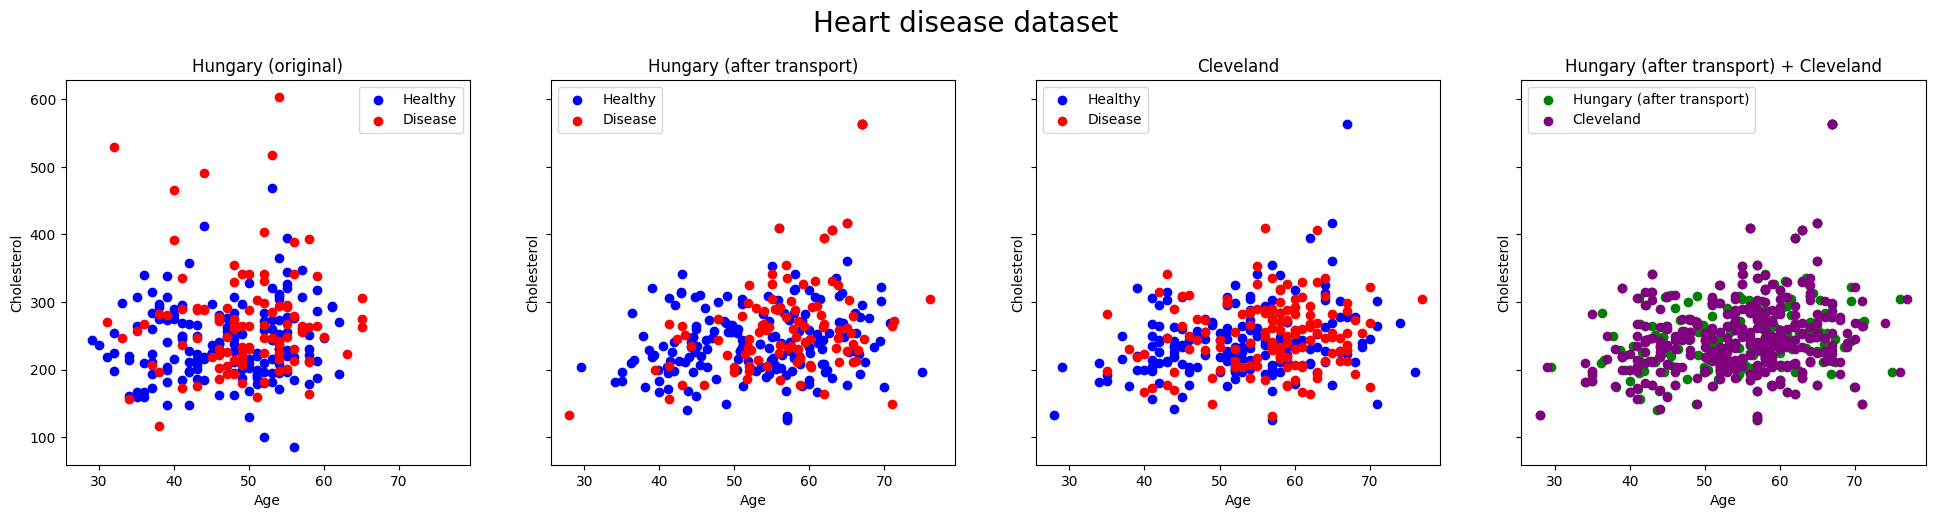

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    1, 4, figsize=(24, 5), sharex=True, sharey=True
)


healthy_points_source = X_source[y_source == 0]
disease_points_source = X_source[y_source == 1]

healthy_points_transport_source = X_transport_source[y_source == 0]
disease_points_transport_source = X_transport_source[y_source == 1]

healthy_points_target = X_target[y_target == 0]
disease_points_target = X_target[y_target == 1]

ax1.scatter(
    healthy_points_source[:, 0], healthy_points_source[:, 1], c="blue", label="Healthy"
)
ax1.scatter(
    disease_points_source[:, 0], disease_points_source[:, 1], c="red", label="Disease"
)

ax2.scatter(
    healthy_points_transport_source[:, 0],
    healthy_points_transport_source[:, 1],
    c="blue",
    label="Healthy",
)
ax2.scatter(
    disease_points_transport_source[:, 0],
    disease_points_transport_source[:, 1],
    c="red",
    label="Disease",
)

ax3.scatter(
    healthy_points_target[:, 0], healthy_points_target[:, 1], c="blue", label="Healthy"
)
ax3.scatter(
    disease_points_target[:, 0], disease_points_target[:, 1], c="red", label="Disease"
)

ax4.scatter(
    X_transport_source[:, 0],
    X_transport_source[:, 1],
    c="green",
    label="Hungary (after transport)",
)
ax4.scatter(X_target[:, 0], X_target[:, 1], c="purple", label="Cleveland")

ax1.set_xlabel("Age")
ax1.set_ylabel("Cholesterol")
ax1.set_title("Hungary (original)")

ax2.set_xlabel("Age")
ax2.set_ylabel("Cholesterol")
ax2.set_title("Hungary (after transport)")

ax3.set_xlabel("Age")
ax3.set_ylabel("Cholesterol")
ax3.set_title("Cleveland")

ax4.set_xlabel("Age")
ax4.set_ylabel("Cholesterol")
ax4.set_title("Hungary (after transport) + Cleveland")

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.suptitle("Heart disease dataset", fontsize=20, y=1.02)
plt.show()

We can see that each point has been tranported to match more closely the target distribution.

Finally, we can see how each point has been tranported.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

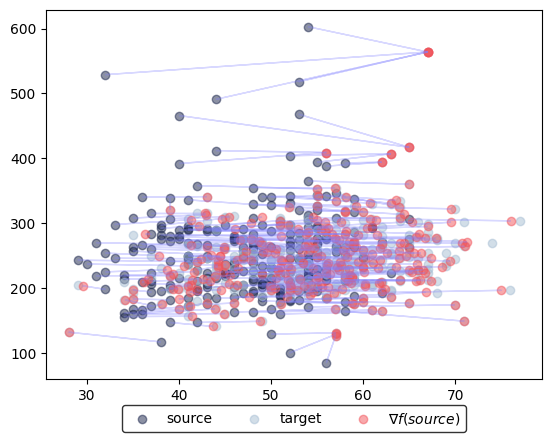

In [ ]:
entropic_map.plot_ot_map(X_source, X_target)